In [1]:
using Distributions, DistributionsAD, Plots, StatsPlots, LinearAlgebra, KernelFunctions, BlockDiagonals, MLDatasets, Zygote, LinearAlgebra

In [2]:
import Base.+, Base.-, Base.*
using Flux


struct Gaussian
    μ
    Σ
end
Flux.@functor Gaussian


+(x::Gaussian, y::Gaussian) = Gaussian(x.μ .+ y.μ, x.Σ .+ y.Σ)
+(x::Gaussian, y::Vector) = Gaussian(x.μ .+ y, x.Σ)
+(x::Vector, y::Gaussian) = Gaussian(x .+ y.μ, y.Σ)

-(x::Gaussian, y::Gaussian) = Gaussian(x.μ .- y.μ, x.Σ .+ y.Σ)
-(x::Gaussian, y::Vector) = Gaussian(x.μ .- y, x.Σ)
-(x::Vector, y::Gaussian) = Gaussian(x .- y.μ, y.Σ)

*(x::Matrix, y::Gaussian) = Gaussian(x*y.μ, (x)*y.Σ*transpose(x))
        
*(x::Gaussian, y::Real) = Gaussian(y.*x.μ, y^2 .*x.Σ)
*(x::Real, y::Gaussian) = Gaussian(x.*y.μ, x^2 .*y.Σ)

Gaussian(m::Gaussian, S) = Gaussian(m.μ, S.+m.Σ)
Distributions.MvNormal(m::Gaussian) = Distributions.MvNormal(m.μ, Matrix(Hermitian(m.Σ.+Diagonal(ones(length(m.μ)).*1e-6))))

In [3]:
mutable struct SEKernel <: KernelFunctions.Kernel
     
    se_variance
    se_lengthscale

end

Flux.@functor SEKernel


SEKernel() = SEKernel(zeros(1,1), zeros(1,1))


function KernelFunctions.kernelmatrix(m::SEKernel,x::Matrix,y::Matrix)

    diffed = sum((Flux.unsqueeze(x,3) .- Flux.unsqueeze(y,2)).^2,dims=1)[1,:,:]
    
    return exp(m.se_variance[1,1]) .* exp.(- 0.5 *exp(m.se_lengthscale[1,1]) .* diffed)

end

KernelFunctions.kernelmatrix(m::SEKernel,x::Matrix) = KernelFunctions.kernelmatrix(m,x,x)


function crossderivativekernel(m::SEKernel,x::Matrix,y::Matrix,i=1)

    diffed = (Flux.unsqueeze(x[i:i,:],3) .- Flux.unsqueeze(y[i:i,:],2))[1,:,:]
    kern = kernelmatrix(m,x,y)
    
    result =  exp(m.se_lengthscale[1,1]) .* diffed .* kern
    
    return result
    
end


crossderivativekernel(m::SEKernel,x::Matrix) = crossderivativekernel(m,x,x)
crossderivativekernel(m::SEKernel,x::Matrix,i::Int) = crossderivativekernel(m,x,x,i)


function doaug(k,n,m)
    
    result = zeros(k,k,n,m,k*n,k*m)
    
    for i in 1:k
        for j in 1:k
            for s in 1:n
                for t in 1:m
                    result[i,j,s,t,((i-1)*n+s),((j-1)*m+t)] = 1.
                end
            end
        end
    end
    
    return result
end
Zygote.@nograd doaug


function derivativekernel(m::SEKernel, x::Matrix, y::Matrix,i=1)
    
    diffed = (Flux.unsqueeze(x[i:i,:],3) .- Flux.unsqueeze(y[i:i,:],2))[1,:,:]

    kern = kernelmatrix(m,x,y)
    
    result =  (exp(m.se_lengthscale[1,1]) .- exp(m.se_lengthscale[1,1]).^2 .* diffed.^2) .* kern
        
    return result
end


derivativekernel(m::SEKernel,x::Matrix) = derivativekernel(m,x,x)
derivativekernel(m::SEKernel,x::Matrix,i::Int) = derivativekernel(m,x,x,i)

derivativekernel (generic function with 4 methods)

In [4]:
struct SVGPG
     
    L
    a
    I
    
    kern
    s
    
end
Flux.@functor SVGPG



SVGPG(X, kern, ndims=1, nind=5) = SVGPG(randn(nind,nind), randn(1,nind), X[:,1:nind], kern, zeros(1,1))

SVGPG(kern, ndims=1, nind=5) = SVGPG(randn(nind,nind), randn(1,nind), rand(ndims,nind).*6 .-3, kern, zeros(1,1))


function (m::SVGPG)(x)
    
    S = m.L*transpose(m.L)
    
    Kmm = kernelmatrix(m.kern,m.I)
    Kmn = kernelmatrix(m.kern,m.I,x)
    Knn = kernelmatrix(m.kern,x)
    
    L = cholesky(Kmm.+Diagonal(ones(size(Kmm,2)).*exp(m.s[1,1]))).L
    v = L\Kmn


    means = transpose(transpose(L)\(L\transpose(m.a)))*Kmn
    covs =  Knn .- transpose(v)*v
    
    return Gaussian(means[:], covs)

end



struct ∂SVGPG
    
    SVGP
    
end
Flux.@functor ∂SVGPG


∂(m::SVGPG) = ∂SVGPG(m)

function (mm::∂SVGPG)(x,i::Int=1)
    
    m = mm.SVGP
    
    S = m.L*transpose(m.L)
    
    Kmm = kernelmatrix(m.kern,m.I)
    Kmn = crossderivativekernel(m.kern,m.I,x,i)
    Knn = derivativekernel(m.kern,x,i)
    
    L = cholesky(Kmm.+Diagonal(ones(size(Kmm,2)).*exp(m.s[1,1]))).L
    v = L\Kmn


    means = transpose(transpose(L)\(L\transpose(m.a)))*Kmn
    covs =  Knn .- transpose(v)*v
    
    return Gaussian(means[:], covs)

end





struct CrossSVGPG
    
    SVGP
    
end
Flux.@functor ∂SVGPG


cross(m::SVGPG) = CrossSVGPG(m)

function (mm::CrossSVGPG)(x,i::Int=1)
    
    m = mm.SVGP
    
    S = m.L*transpose(m.L)
    
    Kmm = kernelmatrix(m.kern,m.I)
    Kmn = crossderivativekernel(m.kern,m.I,x,i)
    Knn = crossderivativekernel(m.kern,x,i)
    
    L = cholesky(Kmm.+Diagonal(ones(size(Kmm,2)).*exp(m.s[1,1]))).L
    v = L\Kmn


    means = transpose(transpose(L)\(L\transpose(m.a)))*Kmn
    covs =  Knn .- transpose(v)*v
    
    return Gaussian(means[:], covs)

end


In [5]:


function get_kldiv(m::SVGPG)
    
    return get_inducing_kldiv(m)
    
end

function get_kldiv(m::SVGPG, x,xmin,xmax,nn)
    
    return get_inducing_kldiv(m)
    
end

function get_inducing_kldiv(m::SVGPG)

    _,mm = size(m.I)
    
    mv = m.a
    Sv = m.L*transpose(m.L)
    
    mp = zeros(1,mm)
    Sp = kernelmatrix(m.kern,m.I)
    
    
    return sum(kldiv(mv,Sv,mp,Sp))

end





function llnormal(x,m,s)
       
    return -0.5 * log(2 * 3.14 * s) - 1/(2*s)*(x-m)^2
    
end

    
function logdetcholesky(X)
    
    m,n = size(X)
    
    return 2 * sum(log.(diag(cholesky(Symmetric(X.+Diagonal(ones(n).*1e-5))).L)))
    
end


function kldiv(m1,S1,m2,S2)
    
    
    _,N = size(m1)
        
    mdiff = m2.-m1
    
    S2L = cholesky(S2.+Diagonal(ones(N).*1e-5))
    S2LL = S2L.L
    S2LU = S2L.U
    
    
    return 0.5*(logdetcholesky(S2)-logdetcholesky(S1) - N + tr(S2LU\(S2LL\S1)) + (mdiff*(S2LU\(S2LL\transpose(mdiff))))[1])

end


function dosample(X,n_sample)
        
    _,N = size(X)
    return randn(n_sample,N)
        
end
Zygote.@nograd dosample

function sample(m::SVGPG, X,n_sample = 10)
    
    model = m(X)
    
    m = Flux.unsqueeze(model.μ,1)
    S = model.Σ
        
    return (dosample(X,n_sample).+m).*Flux.unsqueeze(sqrt.(diag(S)),1)
    
end


function elbo(m::SVGPG, X, y)
    
    N = size(X,2)
    
    G = m(X)
    mu = G.μ
    S = G.Σ
    
    s = diag(S)[:]
    s2 = exp(m.s[1,1])
    
    ll = sum(llnormal.(y[:],mu[:],s.+s2) .- 0.5 .* (s./s2))
    
    
    kld = get_inducing_kldiv(m)
    
    return (ll - kld)/N
end

elbo (generic function with 1 method)

In [6]:
using CSV, DataFrames

In [7]:
df = CSV.File("./data/boston_housing.csv") |> DataFrame
X = Matrix(transpose(Matrix(df[:,1:end-1])))
X = (X.-mean(X,dims=2))./std(X,dims=2)

y = Matrix(transpose(Matrix(df[:,end:end])))
y = (y.-mean(y))./std(y)

1×506 Matrix{Float64}:
 0.159528  -0.101424  1.32294  1.18159  …  0.148655  -0.057932  -1.1561

In [8]:
using Random
Random.seed!(123)
test = SVGPG(SEKernel(),size(X,1),10)

params = Flux.params(test)
opt = ADAM(0.01)


for i in 1:1000
    
    grads = Zygote.gradient(()-> - elbo(test,X,y), params)
    Flux.Optimise.update!(opt,params,grads)
    
    if i % 50 == 0
        println(elbo(test,X,y))
    end
    
end

-1.787838372514235
-1.6639199444825037
-1.4498767482369461
-1.2258012425979938
-1.075798376041054
-1.0169914389787615
-0.9972777803698507
-0.9865953694476983
-0.9789938650719523
-0.9733067551984524
-0.9685126957495097
-0.9640566712814599
-0.9597350136031695
-0.9554424634264569
-0.95111638740398
-0.9467233163673119
-0.9422568743243706
-0.9377289000912533
-0.933169883382998
-0.928608590678556


In [9]:
∂test = ∂(test)
ctest = cross(test)

CrossSVGPG(SVGPG([-0.3361957256950135 -0.4139846720777829 … 0.8479438739076691 -0.006364626014071501; -0.3168148743820047 -0.44761906622593445 … 0.40069855126749876 0.2720665613815534; … ; -0.40018346374721697 -0.26358533950821994 … 0.4530094220838591 0.6202895446276312; -0.1920994076427409 -0.6921446801346466 … 0.6403313976547865 0.33013426414814134], [-1.2336474360137 -1.6616024499766466 … -0.4314583035623649 -1.2886074353698966], [-1.2445851216905557 0.6934009650655871 … -0.6062055197721463 0.1657325085464727; -0.6620244409803813 -0.5473643833228264 … 5.1431435040220475 -0.06473720119218722; … ; 1.0633393466800911 -6.1670416333555815 … 0.3729391375184454 0.3267536294047076; 0.8801078257309138 1.5739761396078444 … -0.17447527351626713 -0.22804270670626361], SEKernel([0.8643517087587735;;], [-5.445299307161286;;]), [-1.7337470560149006;;]))

In [10]:
function getIGdist(m::SVGPG, x, i)
    
    ∂test = ∂(m)
    alpha = Matrix(transpose(collect(0.1:0.1:1)[:,:]))
    xa = x.*alpha
    G = ones(1,10)./10
    
    
    gpost = ∂test(xa,i)
    
    mup, Sp = gpost.μ, gpost.Σ
    
    return Gaussian((G*mup)[:], Matrix(G*Sp*transpose(G)))
    
    
end

getIGdist (generic function with 1 method)

In [11]:
meanExps = hcat([[getIGdist(test,X[:,j:j],i).μ[1] for i in 1:size(X,1)] for j in 1:size(X,2)]...)
varExps = hcat([[getIGdist(test,X[:,j:j],i).Σ[1] for i in 1:size(X,1)] for j in 1:size(X,2)]...)

13×506 Matrix{Float64}:
 0.00575527  0.00568988  0.00575677  …  0.00563356  0.00562461  0.00560612
 0.0050941   0.00515162  0.00511117     0.00533215  0.00532094  0.00530155
 0.00713763  0.00715737  0.0071857      0.00717791  0.00717452  0.00716508
 0.00508244  0.005135    0.00509512     0.005156    0.00516543  0.00518767
 0.00743186  0.00741451  0.00745395     0.00739737  0.00739216  0.00737552
 0.00570753  0.00590516  0.00568065  …  0.00593966  0.00598183  0.00613221
 0.00583422  0.00574832  0.00575997     0.0057761   0.00576759  0.00574646
 0.00539819  0.00544129  0.00540298     0.00551071  0.00551103  0.0055074
 0.00742675  0.00742433  0.00743568     0.00742705  0.00742535  0.00742189
 0.00815398  0.00815186  0.00815927     0.00814113  0.00814167  0.00814457
 0.00436401  0.00430443  0.00433882  …  0.004363    0.00435575  0.00434363
 0.00469725  0.00463856  0.00466851     0.00453699  0.0045291   0.00454966
 0.00673635  0.00677579  0.0067255      0.00672049  0.00673403  0.00677057

In [12]:
mean(meanExps,dims=2)[:]

13-element Vector{Float64}:
 -0.09074283533295686
  0.05855010823464675
 -0.02121133403449327
  0.07461269166721071
 -0.11227323733160163
  0.37067641167547516
 -0.04371083454819298
 -0.22780913592581747
  0.11891127850557964
 -0.11105280524886563
 -0.18781657176457306
  0.09785459777433494
 -0.3314071120681826

In [13]:
mean(varExps,dims=2)[:]

13-element Vector{Float64}:
 0.005573150652841742
 0.005237626364343091
 0.007193126750225507
 0.005240308079822814
 0.00739560197458427
 0.006070182166528621
 0.005854351611668199
 0.005549596521953061
 0.007431213799482495
 0.008132562280407691
 0.004485831452226545
 0.004484121521531703
 0.006797195847737194

In [14]:
names(df)

14-element Vector{String}:
 "crim"
 "zn"
 "indus"
 "chas"
 "nox"
 "rm"
 "age"
 "dis"
 "rad"
 "tax"
 "ptratio"
 "black"
 "lstat"
 "medv"

In [15]:
meanExps = [getIGdist(test,X[:,1:1],i).μ[1] for i in 1:size(X,1)]
varExps = [getIGdist(test,X[:,1:1],i).Σ[1] for i in 1:size(X,1)]

13-element Vector{Float64}:
 0.0057552680955093765
 0.005094096340924181
 0.007137632542157548
 0.005082442898283095
 0.007431860089314747
 0.005707526999397433
 0.005834222871275806
 0.005398193195010088
 0.007426754309569061
 0.008153978469948054
 0.004364014888577733
 0.004697246050957424
 0.006736345368139684

In [16]:
meanExps = [getIGdist(test,5 .* ones(13,1),i).μ[1] for i in 1:size(X,1)]
varExps = [getIGdist(test,5 .*ones(13,1),i).Σ[1] for i in 1:size(X,1)]

13-element Vector{Float64}:
 0.005571103939943817
 0.005976594345092191
 0.007230061279880407
 0.006233476671775609
 0.00725707662863905
 0.006503914744623249
 0.006469146705547927
 0.006352941276362393
 0.007343950122572113
 0.007822109903264148
 0.005782671992965227
 0.005098770051783223
 0.007238990781442822

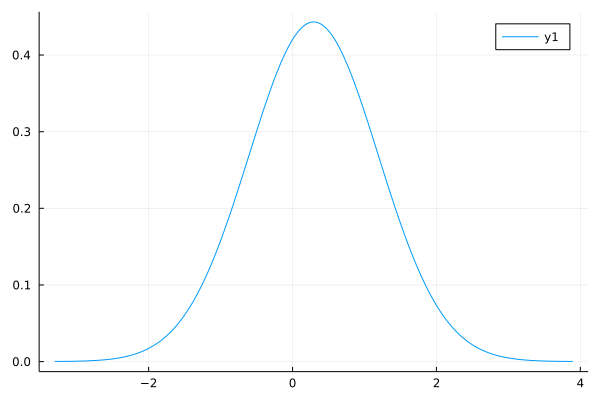

In [17]:
density(meanExps[6,:])

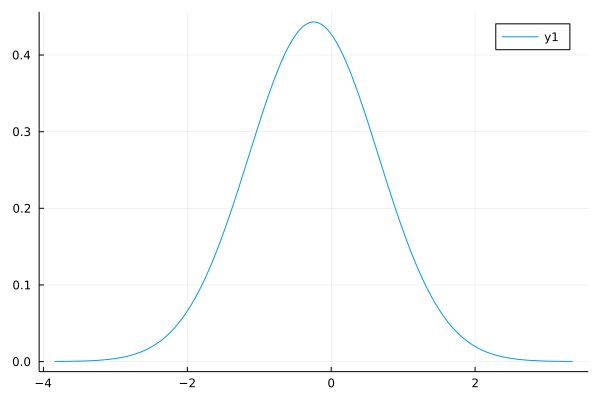

In [18]:
density(meanExps[13,:])

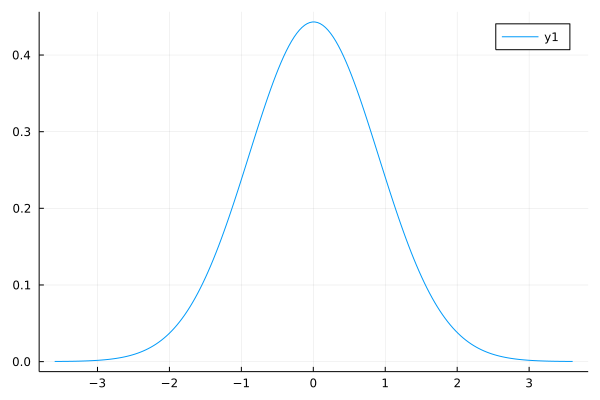

In [19]:
density(varExps[12,:])